In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Install dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5])
    b = -0.7
    tmp = np.sum(w * x) + b
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1


def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-0.5, -0.5])
    b = 0.7
    tmp = np.sum(w * x) + b
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1


def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5])
    b = -0.2
    tmp = np.sum(w * x) + b
    if tmp <= 0:
        return 0
    elif tmp > 0:
        return 1


def XOR(x1, x2):
    return AND(NAND(x1, x2), OR(x1, x2))

<IPython.core.display.Javascript object>

#### Activation Functions

In [4]:
def step_function(x):
    #     y = x > 0
    #     return y.astype(np.int)
    return np.array(x > 0, dtype=int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def identity_function(x):
    return x


def softmax(x):
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x)

<IPython.core.display.Javascript object>

#### Visualize activation functions above

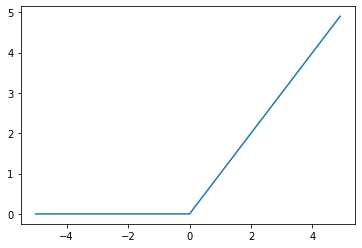

<IPython.core.display.Javascript object>

In [5]:
x = np.arange(-5, 5, 0.1)
y = relu(x)
plt.plot(x, y)
# plt.ylim(-0.1, 1.1)
plt.show()

In [6]:
def init_network():
    network = {}
    network["W1"] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network["b1"] = np.array([0.1, 0.2, 0.3])
    network["W2"] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network["b2"] = np.array([0.1, 0.2])
    network["W3"] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network["b3"] = np.array([0.1, 0.2])
    return network


def forward(network, x):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    b1, b2, b3 = network["b1"], network["b2"], network["b3"]

    x = np.dot(x, W1) + b1
    x = sigmoid(x)
    x = np.dot(x, W2) + b2
    x = sigmoid(x)
    x = np.dot(x, W3) + b3
    return identity_function(x)


network = init_network()
x = np.array([1, 0.5])
y = forward(network, x)
print(y)

[0.31682708 0.69627909]


<IPython.core.display.Javascript object>

#### Load mnist dataset

In [7]:
import sys, os

sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from PIL import Image


def img_show(img):
    img = Image.fromarray(np.uint8(img))
    img.show()


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)
img = x_train[0]
label = t_train[0]
print(label)

print(img.shape)
img = img.reshape(28, 28)
img_show(img)

5
(784,)


<IPython.core.display.Javascript object>

#### Inference using pretrained model

In [8]:
import pickle


def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(
        normalize=True, flatten=True, one_hot_label=False
    )
    return x_test, t_test


def init_network():
    with open("sample_weight.pkl", "rb") as f:
        network = pickle.load(f)
    return network


<IPython.core.display.Javascript object>

In [9]:
x, t = get_data()
network = init_network()

batch_size = 100
acc_cnt = 0
for i in range(0, len(x), batch_size):
    x_batch = x[i : i + batch_size]
    y = forward(network, x_batch)
    p = np.argmax(y, axis=1)
    acc_cnt += np.sum(p == t[i : i + batch_size])

print("Accuracy :" + str(float(acc_cnt) / len(x)))

Accuracy :0.9352


<IPython.core.display.Javascript object>

#### Loss function

In [10]:
def sum_squared_err(y, t):
    return 0.5 * np.sum((y - t) ** 2)


def cross_entropy_err(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    delta = 1e-7
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size


<IPython.core.display.Javascript object>

#### Load mnist dataset again

In [11]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


<IPython.core.display.Javascript object>

In [12]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

<IPython.core.display.Javascript object>

In [13]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)


def _numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for id in range(x.size):
        tmp_val = x[id]
        x[id] = tmp_val + h
        fx1 = f(x)

        x[id] = tmp_val - h
        fx2 = f(x)

        grad[id] = (fx1 - fx2) / (2 * h)
        x[id] = tmp_val

    return grad


def numerical_gradient_2d(f, xs):
    if xs.ndim == 1:
        return _numerical_gradient(f, xs)
    else:
        grad = np.zeros_like(xs)
        for i, x in enumerate(xs):
            grad[i] = _numerical_gradient(f, x)
        return grad

<IPython.core.display.Javascript object>

### Gradient descent

In [14]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x

<IPython.core.display.Javascript object>

#### Simple net

In [15]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        prediction = softmax(self.predict(x))
        return cross_entropy_err(prediction, t)

<IPython.core.display.Javascript object>

In [16]:
simple_net = simpleNet()
print(simple_net.W)

[[-0.67595793  0.96955799  1.32669902]
 [ 0.18469408  0.21010664 -0.5036905 ]]


<IPython.core.display.Javascript object>

In [17]:
x = np.array([0.6, 0.9])
p = simple_net.predict(x)
print(p)

[-0.23935009  0.77083077  0.34269796]


<IPython.core.display.Javascript object>

In [18]:
np.argmax(p)

1

<IPython.core.display.Javascript object>

In [19]:
t = np.array([0, 0, 1])
simple_net.loss(x, t)

1.1291873176618032

<IPython.core.display.Javascript object>

In [20]:
from operator import itemgetter


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {
            "W1": weight_init_std * np.random.randn(input_size, hidden_size),
            "b1": np.zeros(hidden_size),
            "W2": weight_init_std * np.random.randn(hidden_size, output_size),
            "b2": np.zeros(output_size),
        }

    def predict(self, x):
        W1, W2, b1, b2 = itemgetter("W1", "W2", "b1", "b2")(self.params)

        x = np.dot(x, W1) + b1
        x = sigmoid(x)
        x = np.dot(x, W2) + b2
        return softmax(x)

    def loss(self, x, t):
        return cross_entropy_err(self.predict(x), t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        return {
            "W1": numerical_gradient_2d(loss_W, self.params["W1"]),
            "b1": numerical_gradient_2d(loss_W, self.params["b1"]),
            "W2": numerical_gradient_2d(loss_W, self.params["W2"]),
            "b2": numerical_gradient_2d(loss_W, self.params["b2"]),
        }

<IPython.core.display.Javascript object>

In [21]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []
train_acc_list = []
test_acc_list = []
iters_num = 1
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)
    for key in {"W1", "b1", "W2", "b2"}:
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test cc are " + str(train_acc) + " " + str(test_acc))

train acc, test cc are 0.10441666666666667 0.1028


<IPython.core.display.Javascript object>

#### Graph Layers for backpropagation

In [22]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        return x + y

    def backward(self, dout):
        return dout, dout


class MutLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


class ReluLayer:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = x <= 0
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout


class SigmoidLayer:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        return dout * (1.0 - self.out) * self.out


class AffineLayer:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return np.dot(dout, self.W.T)


class SoftmaxWithLossLayer:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_err(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        return (self.y - self.t) / batch_size

<IPython.core.display.Javascript object>

#### Twolayer network with Graph classes

In [23]:
from collections import OrderedDict


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {
            "W1": weight_init_std * np.random.randn(input_size, hidden_size),
            "b1": np.zeros(hidden_size),
            "W2": weight_init_std * np.random.randn(hidden_size, output_size),
            "b2": np.zeros(output_size),
        }

        self.layers = OrderedDict(
            {
                "Affine1": AffineLayer(self.params["W1"], self.params["b1"]),
                "Relu1": ReluLayer(),
                "Affine2": AffineLayer(self.params["W2"], self.params["b2"]),
            }
        )
        self.lastLayer = SoftmaxWithLossLayer()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        # Forward
        self.loss(x, t)

        # Backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        return {
            "W1": self.layers["Affine1"].dW,
            "b1": self.layers["Affine1"].db,
            "W2": self.layers["Affine2"].dW,
            "b2": self.layers["Affine2"].db,
        }

<IPython.core.display.Javascript object>

In [24]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []
train_acc_list = []
test_acc_list = []
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)
    for key in {"W1", "b1", "W2", "b2"}:
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc are " + str(train_acc) + " " + str(test_acc))

train acc, test acc are 0.11823333333333333 0.1253
train acc, test acc are 0.09871666666666666 0.098


<IPython.core.display.Javascript object>

#### How to update hyperparameters

In [25]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, valu in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


class AdaGrad:
    def __init_(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

<IPython.core.display.Javascript object>

### Convolutional Neural Network

In [26]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(
        0, 3, 4, 5, 1, 2
    )
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad : H + pad, pad : W + pad]


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], "constant")
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    return col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)

<IPython.core.display.Javascript object>

In [27]:
x1 = np.random.rand(10, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
col1.shape

(90, 75)

<IPython.core.display.Javascript object>

In [28]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.x = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape

        self.x = x
        self.col = im2col(x, FH, FW, self.stride, self.pad)
        self.col_W = self.W.reshape(FN, -1).T

        out = np.dot(self.col, self.col_W) + self.b
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        return out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)

        return col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

<IPython.core.display.Javascript object>

In [29]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        self.x = x
        self.arg_max = np.argmax(col, axis=1)

        out = np.max(col, axis=1)

        return out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.argmax.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape * (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)

        return col2im(
            dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad
        )

<IPython.core.display.Javascript object>

#### Simple Convolutional Network

In [33]:
class SimpleConvNet:
    def __init__(
        self,
        input_dim=(1, 28, 28),
        conv_param={"filter_num": 30, "filter_size": 5, "pad": 0, "stride": 1},
        hidden_size=100,
        output_size=10,
        weight_init_std=0.01,
    ):
        filter_num, filter_size, filter_pad, filter_stride = itemgetter(
            "filter_num", "filter_size", "pad", "stride"
        )(conv_param)
        input_size = input_dim[1]
        conv_output_size = (
            input_size - filter_size + 2 * filter_pad
        ) / filter_stride + 1
        pool_output_size = int(
            filter_num * (conv_output_size / 2) * (conv_output_size / 2)
        )

        # Init parameters
        self.params = {
            "W1": weight_init_std
            * np.random.randn(filter_num, input_dim[0], filter_size, filter_size),
            "b1": np.zeros(filter_num),
            "W2": weight_init_std * np.random.randn(pool_output_size, hidden_size),
            "b2": np.zeros(hidden_size),
            "W3": weight_init_std * np.random.randn(hidden_size, output_size),
            "b3": np.zeros(output_size),
        }

        # Layers
        self.layers = OrderedDict(
            {
                "Conv1": Convolution(
                    self.params["W1"],
                    self.params["b1"],
                    conv_params["stride"],
                    conv_param["pad"],
                ),
                "Relu1": ReluLayer(),
                "Pool1": Pooling(pool_h=2, pool_w=2, stride=2),
                "Affine1": AffineLayer(self.params["W2"].self.params["b2"]),
                "Relu2": ReluLayer(),
                "Affine2": AffineLayer(self.params["W3"], self.params["b3"]),
            }
        )

        self.last_layer = SoftmaxWithLossLayer()

    def predict(self, x):
        for l in self.layers.values():
            x = l.forward(x)
        return x

    def loss(self, x, t):
        return self.last_layer.forward(self.predict(x), t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size : (i + 1) * batch_size]
            tt = t[i * batch_size : (i + 1) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads["W" + str(idx)] = numerical_gradient(
                loss_w, self.params["W" + str(idx)]
            )
            grads["b" + str(idx)] = numerical_gradient(
                loss_w, self.params["b" + str(idx)]
            )

        return grads

    def gradient(self, x, t):
        # Forward
        self.loss(x, t)

        # Backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for l in layers:
            dout = l.backward(dout)

        return {
            "W1": self.layers["Conv1"].dW,
            "b1": self.layers["Conv1"].db,
            "W2": self.layers["Affine1"].dW,
            "b2": self.layers["Affine1"].db,
            "W3": self.layers["Affine2"].dW,
            "b3": self.layers["Affine2"].db,
        }

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, "wb") as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, "rb") as f:
            params = pickle.load(f)

        for key, val in params.items():
            self.params[key] = val
        for i, key in enumerate(["Conv1", "Affine1", "Affine2"]):
            self.layers[key].W = self.params["W" + str(i + 1)]
            self.layers[key].b = self.params["b" + str(i + 1)]

<IPython.core.display.Javascript object>